In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import sys


In [2]:
#setting up parameters
weights = [12, 13, 14]
nWeights = len(weights)
k = [2, 3, 4]
l = np.linspace(1, 15, 29)
sampling_rate = 200
duration = 240 
time = np.linspace(0,duration, duration*sampling_rate)
nodes = 116 
stimulus_node_ind = 42
print(time.shape)
path_to_data = "/m/nbe/scratch/join-e3200-kuramoto/source/results/metastable_states/2023-3-21_clin_node43"

(48000,)


[ 4000  4191  4395  4595  4790  4979  5173  5361  5574  5786  5990  6205
  6428  6633  6858  7067  7263  7465  7655  7842  8035  8232  8454  8661
  8855  9052  9238  9442  9656  9873 10067 10291 10494 10708 10929 11125
 11346 11547 11748 11941 12143 12328 12535 12729 12940 13160 13351 13569
 13786 13974 14184 14390 14600 14813 15035 15224 15418 15621 15825 16036
 16248 16469 16666 16862 17056 17272 17463 17672 17871 18068 18292 18492
 18678 18898 19113 19335 19546 19761 19954 20171 20396 20595 20814 21034
 21225 21442 21652 21867 22073 22275 22484 22704 22923 23134 23321 23517
 23702 23924 24147 24338 24528 24718 24922 25117 25330 25552 25777 25981
 26180 26399 26617 26827 27037 27250 27469 27660 27875 28099 28289 28503
 28695 28891 29087 29305 29524 29709 29910 30116 30303 30490 30677 30901
 31115 31320 31530 31739 31964 32183 32386 32596 32820 33042 33241 33452
 33638 33860 34056 34256 34448 34667 34864 35060 35282 35472 35662 35865
 36083 36274 36482 36672 36888 37096 37320 37511 37

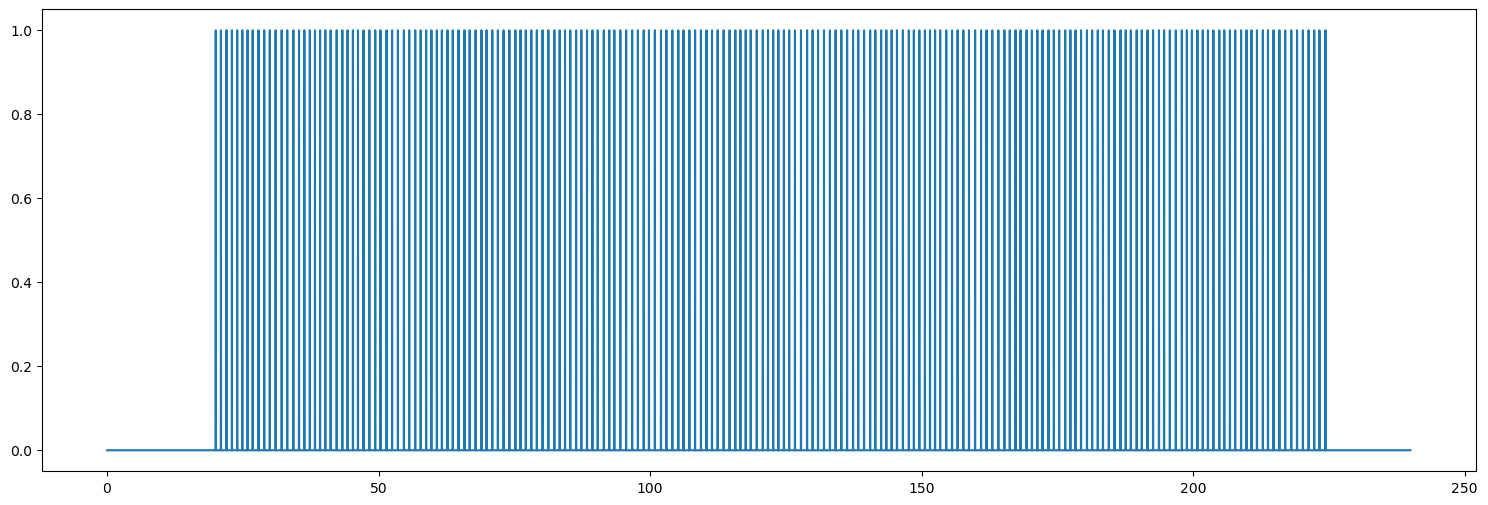

In [3]:
#loading the stimulus vector
stimulus_vector = np.load('npy_files/sv_200_1s.npy')
pulse_onsets = np.load('npy_files/po_200_1s.npy')
n_trials = len(pulse_onsets)
start = 0*sampling_rate
end = duration*sampling_rate
fig, ax = plt.subplots()
time = np.linspace(0, duration, duration*sampling_rate)
ax.plot(time[start:end], stimulus_vector[start:end])
fig.set_size_inches(18.5, 6)
print(pulse_onsets)

In [4]:
# Load weighted series
data_k_3 = np.zeros([nodes, nWeights, l.shape[0], duration*sampling_rate], dtype = 'complex_')
data_k_4 = np.zeros([nodes, nWeights, l.shape[0], duration*sampling_rate], dtype = 'complex_')
data_k_2 = np.zeros([nodes, nWeights, l.shape[0], duration*sampling_rate], dtype = 'complex_')
for w, w_val in enumerate(weights):
    for i, l_val in enumerate(l):
        data_k_2[:,w,i,:] = np.load(f"{path_to_data}/pr_{k[0]}_{l_val}_{w}.npy")
        data_k_3[:,w,i,:] = np.load(f"{path_to_data}/pr_{k[1]}_{l_val}_{w}.npy")
        data_k_4[:,w,i,:] = np.load(f"{path_to_data}/pr_{k[2]}_{l_val}_{w}.npy")
        

In [5]:
#Making surrogate data
surr_k_3 = np.zeros([nodes, nWeights, l.shape[0], duration*sampling_rate], dtype = 'complex_')
surr_k_4 = np.zeros([nodes, nWeights, l.shape[0], duration*sampling_rate], dtype = 'complex_')
surr_k_2 = np.zeros([nodes, nWeights, l.shape[0], duration*sampling_rate], dtype = 'complex_')
for i in tqdm(range(nodes)):
    perm = np.random.permutation(np.arange(duration*sampling_rate)) #random sequence of indeces to shuffle data across time
    surr_k_2[i] = data_k_2[i][:,:,perm,]
    surr_k_3[i] = data_k_3[i][:,:,perm,]
    surr_k_4[i] = data_k_4[i][:,:,perm,]

100%|██████████| 116/116 [01:37<00:00,  1.19it/s]


In [5]:
#Extracting the trials from the data
#start of trial 50 samples before the pulse (calculated from pulse_onsets)
#End of the trial start + 100 samples
trial_len=150
k_2_trials = np.zeros([nodes, l.shape[0], n_trials, 150], dtype='complex_')
k_3_trials = np.zeros([nodes, l.shape[0], n_trials, 150], dtype='complex_')
k_4_trials = np.zeros([nodes, l.shape[0], n_trials, 150], dtype='complex_')

data_surr_k2 = np.zeros((nodes, l.shape[0], n_trials, trial_len), dtype='complex_')
data_surr_k3 = np.zeros((nodes, l.shape[0], n_trials, trial_len), dtype='complex_')
data_surr_k4 = np.zeros((nodes, l.shape[0], n_trials, trial_len), dtype='complex_')
weight_ind = 0 #(12, 13, 14) calculating activations only for weight 12
baseline_range = 50
trial_start = pulse_onsets - baseline_range #start of the baseline
for l_ind, l_val in enumerate(l):
    for t, start in enumerate(trial_start):
        k_2_trials[:,l_ind,t,:] = data_k_2[:,weight_ind,l_ind,start:start+150]
        k_3_trials[:,l_ind,t,:]=data_k_3[:,weight_ind,l_ind,start:start+150]
        k_4_trials[:,l_ind,t,:]=data_k_4[:,weight_ind,l_ind,start:start+150]
        data_surr_k2[:,l_ind,t,:] = surr_k_2[:,weight_ind,l_ind,start:start+150]
        data_surr_k3[:,l_ind,t,:] = surr_k_3[:,weight_ind,l_ind,start:start+150]
        data_surr_k4[:,l_ind,t,:] = surr_k_4[:,weight_ind,l_ind,start:start+150]
        

print(k_3_trials.shape)

(116, 29, 200, 150)


In [6]:
#PLF over trials

def get_PLF(data, axis):
    #Calculates PLF over trials
    if len(data.shape) < 4:
        sys.exit("Requires 4D data")
    PLF = np.abs(np.mean(data/np.abs(data), axis=axis))  
    return PLF

In [7]:
k_2_average = get_PLF(k_2_trials, axis=2)
k_3_average = get_PLF(k_3_trials, axis=2)
k_4_average = get_PLF(k_4_trials, axis=2)

k_2_surr_average = get_PLF(data_surr_k2, axis=2)
k_3_surr_average = get_PLF(data_surr_k3, axis=2)
k_4_surr_average = get_PLF(data_surr_k4, axis=2)


(116, 29, 150)


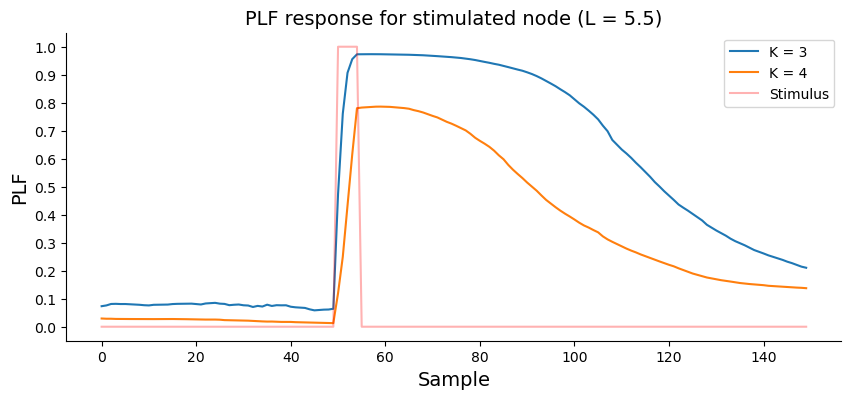

In [8]:
import ipywidgets as w
print(k_3_average.shape)
node = 42
l_val = 9
trial_length = np.arange(150)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(trial_length, k_3_average[node][l_val], label="K = 3")
ax.plot(trial_length, k_4_average[node][l_val], label="K = 4")
ax.plot(stimulus_vector[pulse_onsets[0] - 50 : pulse_onsets[0] + 100], label="Stimulus", c='red', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel("PLF", fontsize=14)
plt.xlabel("Sample", fontsize=14)
plt.yticks(np.linspace(0,1, 11))
plt.title(f"PLF response for stimulated node (L = {l[l_val]})", fontsize=14)
plt.legend()
plt.show()



In [10]:
#calculating the baselines and PLF peaks to get nPLF values

baselines_k2 = np.zeros((nodes, l.shape[0]))
peaks_k2 = np.zeros((nodes, l.shape[0]))

baselines_k3 = np.zeros((nodes, l.shape[0]))
peaks_k3 = np.zeros((nodes, l.shape[0]))

baselines_k4 = np.zeros((nodes, l.shape[0]))
peaks_k4 = np.zeros((nodes, l.shape[0]))

baselines_surr_k2 = np.zeros((nodes, l.shape[0]))
peaks_surr_k2 = np.zeros((nodes, l.shape[0]))

baselines_surr_k3 = np.zeros((nodes, l.shape[0]))
peaks_surr_k3 = np.zeros((nodes, l.shape[0]))

baselines_surr_k4 = np.zeros((nodes, l.shape[0]))
peaks_surr_k4 = np.zeros((nodes, l.shape[0]))
for w in range(l.shape[0]):
    baselines_k2[:,w] = np.mean(k_2_average[:,w,:50],axis=-1)
    peaks_k2[:,w] = abs(k_2_average[:,w,50:100]).max(axis=-1)
    
    baselines_k3[:,w] = np.mean(k_3_average[:,w,:50],axis=-1)
    peaks_k3[:,w] = abs(k_3_average[:,w,50:100]).max(axis=-1)
    
    baselines_k4[:,w] = np.mean(k_4_average[:,w,:50],axis=-1)
    peaks_k4[:,w] = abs(k_4_average[:,w,50:100]).max(axis=-1)
    
    baselines_surr_k2[:,w] = np.mean(k_2_surr_average[:,w,:50],axis=-1)
    peaks_surr_k2[:,w] = abs(k_2_surr_average[:,w,50:100]).max(axis=-1)
    
    baselines_surr_k3[:,w] = np.mean(k_3_surr_average[:,w,:50],axis=-1)
    peaks_surr_k3[:,w] = abs(k_3_surr_average[:,w,50:100]).max(axis=-1)
    
    baselines_surr_k4[:,w] = np.mean(k_4_surr_average[:,w,:50],axis=-1)
    peaks_surr_k4[:,w] = abs(k_4_surr_average[:,w,50:100]).max(axis=-1)

baselines_k2 = np.mean(baselines_k2, axis=0) #mean over nodes to reduce randomness
baselines_k3 = np.mean(baselines_k3, axis=0)
baselines_k4 = np.mean(baselines_k4, axis=0)

baselines_surr_k2 = np.mean(baselines_surr_k2, axis=0)
baselines_surr_k3 = np.mean(baselines_surr_k3, axis=0)
baselines_surr_k4 = np.mean(baselines_surr_k4, axis=0)
print(baselines_k3.shape)

(29,)


In [11]:
thresh = 2.43

nPLF_k3 = peaks_k3 / baselines_k3
nPLF_k4 = peaks_k4 / baselines_k4



/tmp/ipykernel_27146/536923007.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 1, 1)


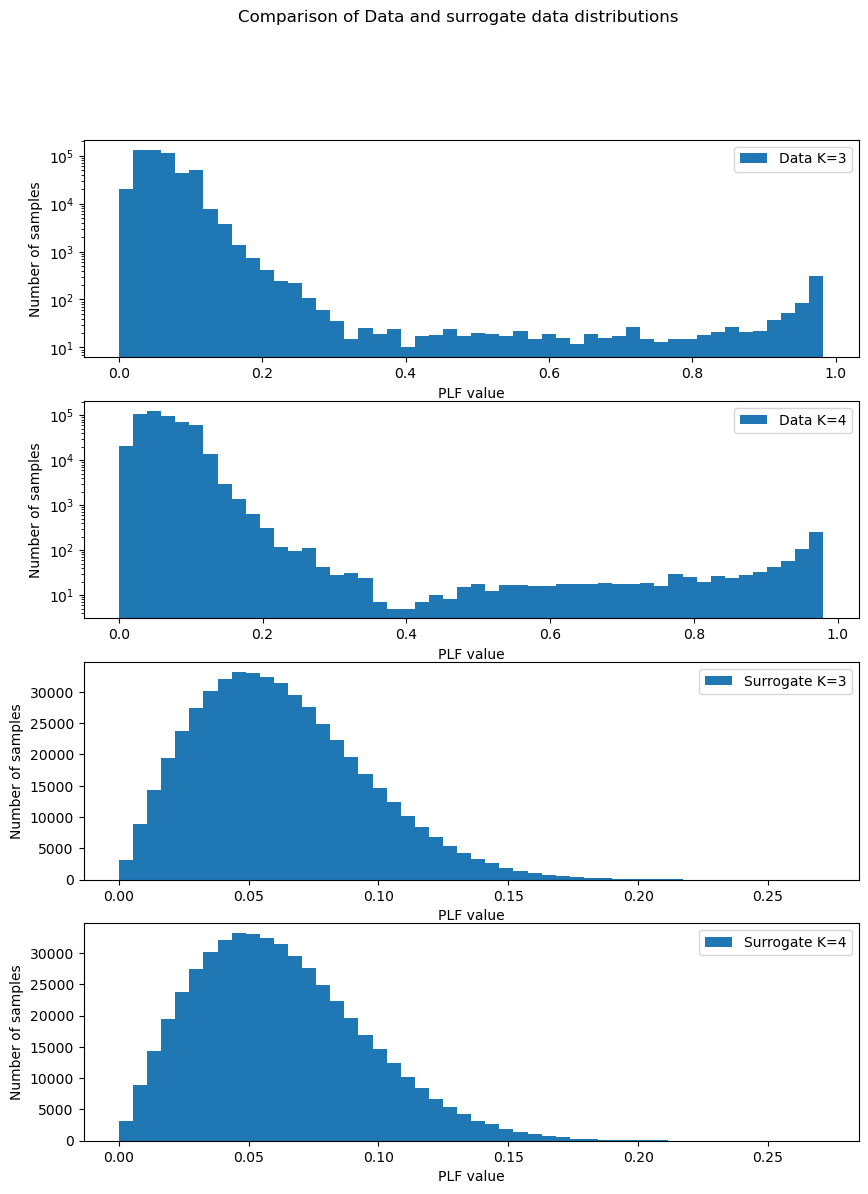

In [12]:

fig, ax = plt.subplots(figsize=(10, 13))
plt.suptitle("Comparison of Data and surrogate data distributions")
plt.subplot(4, 1, 1)
plt.semilogy()
plt.hist(k_3_average.flatten(), bins=50, label="Data K=3")
plt.legend()
plt.xlabel("PLF value")
plt.ylabel("Number of samples")
plt.subplot(4,1,2)
plt.semilogy()
plt.hist(k_4_average.flatten(), bins=50, label="Data K=4")
plt.legend()
plt.xlabel("PLF value")
plt.ylabel("Number of samples")
plt.subplot(4,1,3)
plt.hist(k_3_surr_average.flatten(), bins=50, label="Surrogate K=3")
plt.legend()
plt.xlabel("PLF value")
plt.ylabel("Number of samples")
plt.subplot(4,1,4)
plt.hist(k_4_surr_average.flatten(), bins=50, label="Surrogate K=4")
plt.legend()
plt.xlabel("PLF value")
plt.ylabel("Number of samples")
plt.show()

Null level data seems rayleigh distributed so we use rayleigh z-score threshold for 95% percentile as threshold value for nPLF. Node activation is significant if nPLF > 2.43

In [14]:
#Calculating the number of activated nodes
thresh = 2.43 #from 95% percentile rayleigh z-score
nPLF_k3 = peaks_k3 / baselines_k3
nPLF_k4 = peaks_k4 / baselines_k4
print(nPLF_k3.shape)
print(sum(nPLF_k3 > thresh))
print(sum(nPLF_k4 > thresh))


num_activated_k3 = np.sum(nPLF_k3 > thresh, axis=0) #Number of activated nodes for each value of L
num_activated_k4 = np.sum(nPLF_k4 > thresh, axis=0)



(116, 29)
[10  2  4  7  8 12  6  6 14 10  4  1  1  1  1  1  1  2  0  1  1  1  1  1
  0  1  1  1  0]
[ 3  3  3  6  8  8 13  9 11 15  1  0  1  1  1  0  1  1  1  0  1  1  1  1
  0  1  1  1  1]


In [ ]:
np.save("num_activated_k2.npy", num_activated_k2)
np.save("num_activated_k3.npy", num_activated_k3)
np.save("num_activated_k4.npy", num_activated_k4)

In [24]:
num_activated_k2 =np.load("num_activated_k2.npy")
num_activated_k3 =np.load("num_activated_k3.npy")
num_activated_k4 =np.load("num_activated_k4.npy")

[10  2  4  7  8 12  6  6 14 10  4  1  1  1  1  1  1  2  0  1  1  1  1  1
  0  1  1  1  0]
[ 3  3  3  6  8  8 13  9 11 15  1  0  1  1  1  0  1  1  1  0  1  1  1  1
  0  1  1  1  1]


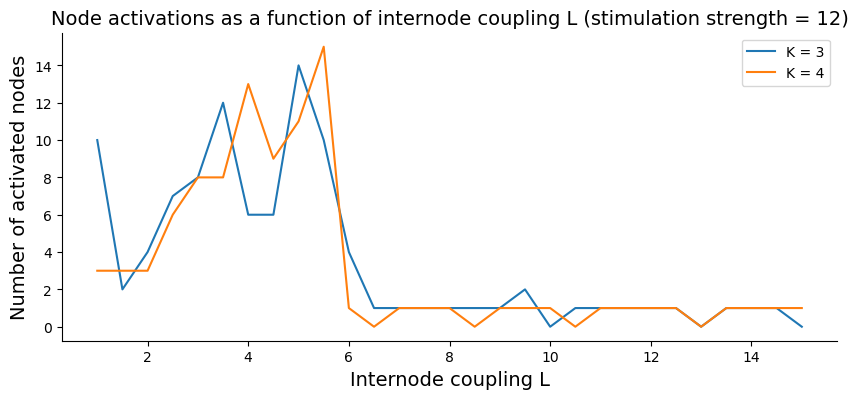

In [15]:

print(num_activated_k3)
print(num_activated_k4)
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(l, num_activated_k3, label="K = 3")
plt.plot(l, num_activated_k4, label = "K = 4")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel("Number of activated nodes", fontsize=14)
plt.xlabel("Internode coupling L", fontsize=14)
plt.title(f"Node activations as a function of internode coupling L (stimulation strength = {weights[weight_ind]})", fontsize=14)
plt.legend()
plt.show()

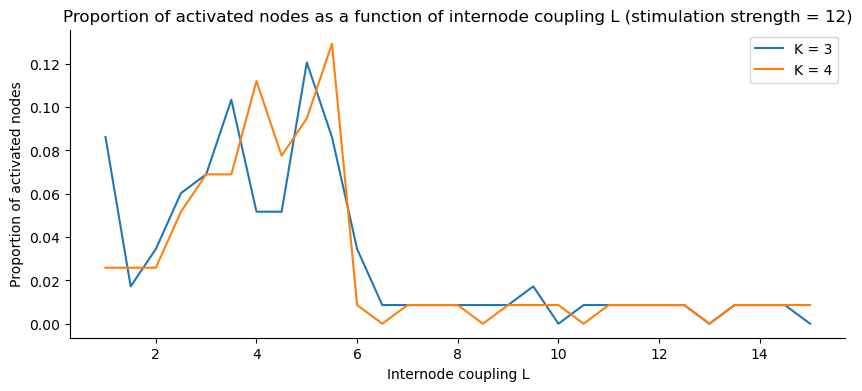

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(l, num_activated_k3/nodes, label="K = 3")
plt.plot(l, num_activated_k4/nodes, label = "K = 4")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.ylabel("Proportion of activated nodes")
plt.xlabel("Internode coupling L")
plt.title(f"Proportion of activated nodes as a function of internode coupling L (stimulation strength = {weights[weight_ind]})")
plt.legend()
plt.show()